In [1]:
import pickle

import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
import sys
import os
import time

In [4]:
from OpenData import *

In [5]:
pkl_dict = unpickle('cifar-100-python/train')
labels=pkl_dict['fine_labels']
images=pkl_dict['data']
labels = np.array(labels,dtype=np.uint8)
images = images / np.float32(256)
X_train = images.reshape((50000,3,32,32))
y_train = labels

In [6]:
pkl_dict = unpickle('cifar-100-python/test')
labels=pkl_dict['fine_labels']
images=pkl_dict['data']
labels = np.array(labels,dtype=np.uint8)
images = images / np.float32(256)
X_test = images.reshape((10000,3,32,32))
y_test = labels

In [7]:
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=128,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=100,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Создаём нейросеть

In [9]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

In [10]:
network = build_cnn(input_var)

In [11]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

In [12]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                        dtype=theano.config.floatX)

In [13]:
pred = test_prediction.argmax(-1)
f_predict = theano.function([input_var], pred)

In [14]:
train_fn = theano.function([input_var, target_var], 
                           loss, 
                           updates=updates,
                           allow_input_downcast=True)

val_fn = theano.function([input_var, target_var], 
                         [test_loss, test_acc],
                         allow_input_downcast=True)

## Обучаем модель

In [15]:
num_epochs = 10

In [16]:
BATCH_SIZE = 128

In [17]:
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, BATCH_SIZE, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
        
    print("Epoch: {}, train:{}, val:{}".format(epoch, 
                                               train_err/train_batches,
                                               val_err/val_batches))

Epoch: 0, train:4.46139440903, val:4.15651885057
Epoch: 1, train:4.11678092113, val:3.85912915682
Epoch: 2, train:3.90550089494, val:3.65711906323
Epoch: 3, train:3.73676773218, val:3.4766873213
Epoch: 4, train:3.58188589658, val:3.28590965271
Epoch: 5, train:3.45972637397, val:3.17193006858
Epoch: 6, train:3.3515718833, val:3.09746139172
Epoch: 7, train:3.27210397781, val:2.99969094533
Epoch: 8, train:3.19932201887, val:2.95267558709
Epoch: 9, train:3.15096353201, val:2.90895035634


# Обрабатываем оставшиеся изображении

In [18]:
y_true = []
y_pred = []
test_size=10000
for i in range(test_size):
    y_true.append(int(y_test[i]))
    y_pred.append(f_predict([X_test[i]])[0])

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
CM = confusion_matrix(y_true, y_pred)

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


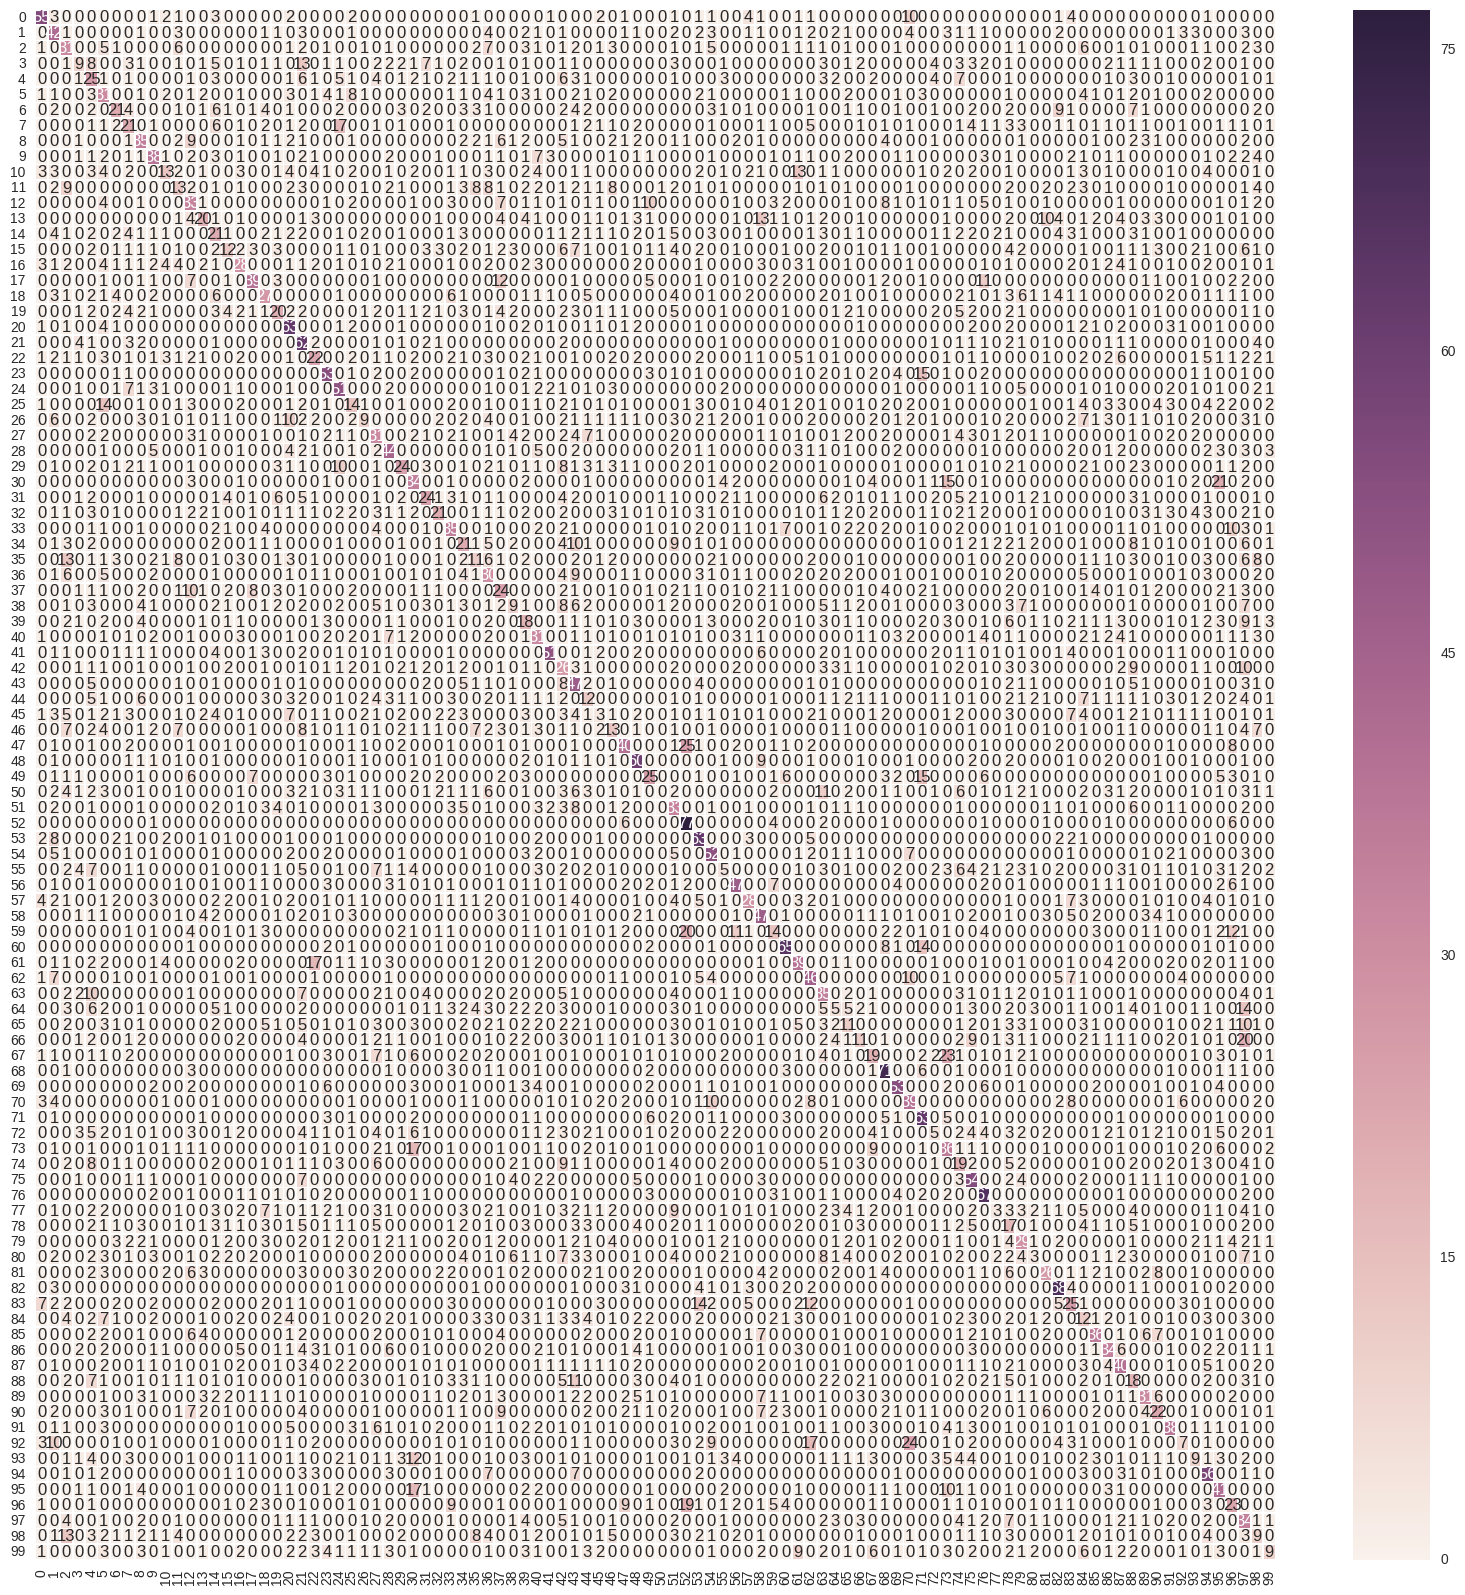

In [21]:
import seaborn as sns

fig = plt.figure(figsize=(20, 20))
sns.heatmap(CM, annot=True, fmt="d", linewidths=.5)
plt.show()

In [22]:
from sklearn.metrics import classification_report
target_names = ['class'+str(i) for i in range(0,100)]
print(classification_report(y_true, y_pred, target_names=target_names))


             precision    recall  f1-score   support

     class0       0.60      0.55      0.58       100
     class1       0.30      0.42      0.35       100
     class2       0.23      0.31      0.26       100
     class3       0.22      0.09      0.13       100
     class4       0.15      0.25      0.19       100
     class5       0.21      0.31      0.25       100
     class6       0.35      0.21      0.26       100
     class7       0.25      0.21      0.23       100
     class8       0.32      0.35      0.34       100
     class9       0.40      0.38      0.39       100
    class10       0.30      0.13      0.18       100
    class11       0.18      0.13      0.15       100
    class12       0.25      0.33      0.28       100
    class13       0.33      0.20      0.25       100
    class14       0.18      0.21      0.19       100
    class15       0.24      0.12      0.16       100
    class16       0.33      0.28      0.30       100
    class17       0.53      0.39      0.45   